# Simulate canonical olfaction as in Qin et al. 2019

Here we are following exactly the notation from their paper

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import differential_entropy
from scipy.stats import norm, rankdata
from scipy.special import psi

In [87]:
class OlfactorySensing():
    def __init__(self, N=100, n=2, M = 30, sigma_0=1e-2, sigma_c=2): 
        self.N = N
        self.n = n
        self.M = M
        self.sigma_0 = sigma_0
        self.sigma_c = sigma_c
        self.set_sigma() 
        self.set_random_W()

    def draw_c(self): 
        # there is a bigger picture problem here--need a generative model for odor mixtures. 
        # Here we're just following Shanshan's paper. At the very least 1) we can make this a more realistic distribution 2) we can plug in Farhad's data of odor mixtures 3) we can estimate a distribution from that or 4) a full generative model.
        c = np.zeros(self.N)
        non_zero_indices = np.random.choice(self.N, self.n, replace=False)
        # Generate log-normal concentrations for these chosen odorants
        concentrations = np.random.lognormal(mean=0, sigma=self.sigma_c, size=self.n)
        c[non_zero_indices] = concentrations
        # we should think about how to do this better. If you put correlation structure in, it should affect both concentration and presence. Otherwise because n << N your mixtures will in practice be uncorrelated. 
        return c
    
    def draw_cs(self, P):
        self.c = np.zeros((self.N, P))
        for p in range(P): 
            self.c[:, p] = self.draw_c()

    def set_sigma(self): 
        self.sigma = lambda x: x / (1 + x) 

    def set_random_W(self): 
        self.W = np.random.normal(loc=0, scale=1, size=(self.M, self.N))

    def compute_activity(self): 
        self.r = self.sigma(self.W @ self.c) + np.random.normal(loc=0, scale=self.sigma_0)

    def compute_entropy_of_r(self):
        entropy = self.compute_sum_of_marginal_entropies() - self.compute_information_of_r()
        self.entropy = entropy 

    def compute_sum_of_marginal_entropies(self):
        marginal_entropies = []
        for m in range(self.M): 
            marginal_entropies.append(differential_entropy(self.r[m, :]))
        return np.sum(marginal_entropies) 
    
    def compute_information_of_r(self): 
        # as in Qin et al. 2019, we use gaussian copula. This is nothing more than transforming your data through inverse normal cdf to have marginal gaussian distributions. 
        M, P = self.r.shape  # [dimension, sample size]
        # Step 1: Transform data to approximate standard normal in each dimension
        G = norm.ppf((rankdata(self.r.T, axis=0) / (P + 1)), loc=0, scale=1)
        bias_correction = 0.5 * np.sum(psi((P - np.arange(1, M + 1) + 1) / 2) - np.log(P / 2))
        # Step 3: Log determinant using Cholesky decomposition
        cov_matrix = np.cov(G, rowvar=False)
        chol_decomp = np.linalg.cholesky(cov_matrix)
        log_det = np.sum(np.log(np.diag(chol_decomp)))
        # Step 4: Mutual information estimate
        I = -(log_det - bias_correction)
        return I

In [88]:
os = OlfactorySensing()


In [89]:
os.draw_cs(P=1000)

In [90]:
os.compute_activity()

In [91]:
os.r.shape

(30, 1000)

# Simple test: more correlated Gaussians should lead to higher mutual information, hence lower entropy

In [105]:
def compute_information(c, os, P): 
    mean = [0] * 30 
    cov = c * np.ones((30, 30))
    for i in range(cov.shape[0]): 
        cov[i, i] = 1
    os.r = np.random.multivariate_normal(mean, cov, size=P).T 
    I = os.compute_information_of_r()
    return I

I = compute_information(0, os, 1000)

In [107]:
Is = []

for c in np.linspace(0, .9, 10): 
    I = compute_information(c, os, 1000)
    Is.append(I) 

Text(0, 0.5, 'MI(r)')

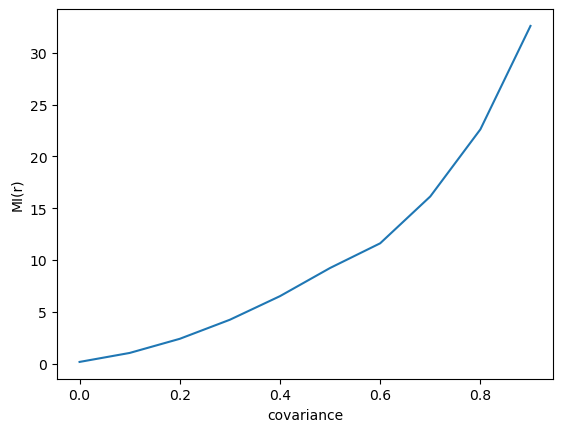

In [110]:
fig, ax = plt.subplots()
ax.plot(np.linspace(0, .9, 10), Is)
ax.set_xlabel('covariance') 
ax.set_ylabel('MI(r)')


In [53]:
os.compute_information_of_r()

3.5061792234316362

In [54]:
os.compute_entropy_of_r()

In [55]:
os.entropy

47.00468612694475